In [55]:
## Develop VAE for kinase resistance predtictions

import numpy as np
import scipy as sp
import os, sys, gzip
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
tf.random.set_seed(69)


# a class to hold kinase information
class kinase:
    def __init__(self, acc, gene):
        self.acc = acc
        self.gene = gene
        self.fasta = ''
        self.group = ''
        self.hmm = {}
        self.oneHotEncoding = {}
        self.domains = {}
        self.hmmsearch = []
        self.access = {}
        self.dihedral = {}
        self.sec = {}
        self.burr = {}
        self.iupred = {}
        self.mechismo = {}
        self.allHomologs = {}
        self.exclParalogs = {}
        self.specParalogs = {}
        self.orthologs = {}
        self.bpso = {}
        self.bpsh = {}


In [56]:
exceptions= ['Q9Y2K2', 'Q15303', 'Q9UIK4', 'P33981', 'P35916',
             'Q99683', 'Q8IVW4', 'Q9H792', 'Q9P286', 'Q86Z02',
             'Q8TF76', 'Q96L34', 'Q13308', 'Q9UK32', 'Q15772',
             'P51617', 'Q9Y3S1', 'Q9C098', 'Q6VAB6', 'P21127',
             'Q13557', 'Q6ZMQ8', 'Q6P0Q8', 'Q8IZE3', 'P51957',
             'O60229', 'Q96RG2', 'Q5VST9', 'Q8WZ42', 'O75962',
             'O95835']

kinases = {}
def loadFasta():
    for line in open('humanKinases.fasta', 'r'):
        #print (line)
        if line[0] == '>':
            acc = line.split('|')[1].replace('\n', '')
            gene = line.split('GN=')[1].split()[0]
            flag = 0
            if acc not in exceptions:
                kinases[acc] = kinase(acc, gene)
                flag = 1
        else:
            if flag == 1:
                kinases[acc].fasta += line.replace('\n', '')

loadFasta()

for line in open('kinases.tsv', 'r'):
    acc = line.split('\t')[7].split('>')[1].split('<')[0]
    if acc in kinases:
        kinases[acc].group = line.split('\t')[4]

print (kinases['P00533'].group)

TK


In [4]:
def read_hmmPkinase():
    hmm = {}
    for line in open('../pfam/Pkinase.hmm'):
        if len(line.split()) > 2:
            if line.split()[-2] == '-' and line.split()[-3] == '-':
                #print (line.split())
                position = int(line.split()[0])
                hmm[position] = {}
                for value, aa in zip(line.split()[1:-5], AA):
                    hmm[position][aa] = float(value)
            elif line.split()[0] == 'HMM':
                AA = line.replace('\n', '').split()[1:]
    return hmm

hmmPkinase = read_hmmPkinase()
#print (hmmPkin[263]['C'])

In [5]:
def hmmsearch():
    '''
    Function to do an hmmsearch of all kinases against Pkinase.hmm
    and store the mappings. Note that some kinases may have more than
    one Pkinase domain.
    '''
    #os.system('hmmsearch -o out.txt ../pfam/Pkinase.hmm humanKinases.fasta')
    flag = 0
    for line in open('out.txt', 'r'):
        if line[:2] == '>>':
            acc = line.split('|')[1]
            flag = 1
            #print (acc)
        if flag == 1 and line.split()!= [] and acc in kinases:
            if '== domain' in line:
                domainNum = line.split('domain')[1].split()[0]
                kinases[acc].domains[domainNum] = {}
            elif line.split()[0] == 'Pkinase':
                hmmStart = int(line.split()[1])
                hmmSeq = line.split()[2]
                hmmEnd = int(line.split()[3])
            elif acc in line.split()[0]:
                kinaseStart = int(line.split()[1])
                kinaseSeq = line.split()[2]
                kinaseEnd = int(line.split()[3])
                for hmmChar, kinaseChar in zip(hmmSeq, kinaseSeq):
                    if hmmChar not in ['.', '-'] and kinaseChar not in ['.', '-']:
                        #kinases[acc].domains[domainNum][kinaseStart] = hmmStart
                        kinases[acc].domains[domainNum][hmmStart] = kinaseStart
                        hmmStart += 1
                        kinaseStart += 1
                    elif hmmChar in ['.', '-']:
                        kinaseStart += 1
                    elif kinaseChar in ['.', '-']:
                        hmmStart += 1
        #print (kinases[acc].domains)
        #sys.exit()
    print (kinases['Q96NX5'].domains['1'][174])
hmmsearch()

196


In [57]:
def createDicForDSSP(dic, position, mutation, value):
    if position not in dic:
        dic[position] = {}
    dic[position][mutation] = float(value)

def dsspScores():
    remove = []
    dir = '/net/home.isilon/ds-russell/mechismoX/analysis/features/data/'
    for num, acc in enumerate(kinases):
        for line in gzip.open(dir + acc[:4] + '/AF-' + acc + '-F1-model_v1.dssp-scores.gz', 'rt'):
            #print (acc, line.split())
            position = int(line.split()[0])
            mutation = line.split()[2] + line.split()[0] + line.split()[10]
            ## Dihedral angles
            torsional = line.split()[18]
            #print (kinases[acc].dihedral)
            createDicForDSSP(kinases[acc].dihedral, position, mutation, torsional)
            ## Secondary structures
            secondary = line.split()[22]
            createDicForDSSP(kinases[acc].sec, position, mutation, secondary)
            ## Accessibility
            accessibility = line.split()[26]
            createDicForDSSP(kinases[acc].access, position, mutation, accessibility)
            ## Buried
            buried = line.split()[30]
            createDicForDSSP(kinases[acc].burr, position, mutation, buried)
            #break
        #break
    print (list(set(remove)))
dsspScores()
print (kinases['Q9NYV4'].burr[3])

[]
{'N3A': -1.7, 'N3C': -2.8, 'N3D': 0.2, 'N3E': 0.5, 'N3F': -1.4, 'N3G': -2.1, 'N3H': -0.2, 'N3I': -1.7, 'N3K': 0.6, 'N3L': -1.6, 'N3M': -1.0, 'N3N': 0.0, 'N3P': -0.4, 'N3Q': 0.3, 'N3R': 0.4, 'N3S': -0.8, 'N3T': -0.6, 'N3V': -1.8, 'N3W': -0.9, 'N3Y': -0.8}


In [58]:
def iupredScores():
    remove = []
    dir = '/net/home.isilon/ds-russell/mechismoX/analysis/features/data/'
    for num, acc in enumerate(kinases):
        if ((num+1)%50 == 0):
            print (num+1)
        for line in gzip.open(dir + acc[:4] + '/AF-' + acc + '-F1-model_v1.iupred.gz', 'rt'):
            #print (acc, line.split())
            position = int(line.split()[0])
            mutation = line.split()[2] + line.split()[0] + line.split()[3]
            ## IUPred
            iupred = float(line.split()[9])
            createDicForDSSP(kinases[acc].iupred, position, mutation, iupred)
            
iupredScores()

50
100
150
200
250
300
350
400
450


In [59]:
def mechismoScores():
    remove = []
    dir = '/net/home.isilon/ds-russell/mechismoX/analysis/features/data/'
    for num, acc in enumerate(kinases):
        if ((num+1)%50 == 0):
            print (num+1)
        for line in gzip.open(dir + acc[:4] + '/AF-' + acc + '-F1-model_v1.mech_intra.gz', 'rt'):
            if line.split()[0] == 'MECH':
                #print (acc, line.split())
                #sys.exit()
                position = int(line.split()[1])
                mutation = line.split()[2] + line.split()[1] + line.split()[3]
                ## Mechismo score
                mechismo = float(line.split()[6])
                createDicForDSSP(kinases[acc].mechismo, position, mutation, mechismo)
            
mechismoScores()

50
100
150
200
250
300
350
400
450


In [24]:
def homologyScores():
    remove = []
    path = '/net/home.isilon/ds-russell/mechismoX/analysis/alignments/data/HUMAN/orthologs_only/'
    for num, acc in enumerate(kinases):
        if ((num+1)%50 == 0):
            print (num+1)
        for dic, fileEnd in zip([kinases[acc].allHomologs, kinases[acc].orthologs, kinases[acc].exclParalogs, kinases[acc].specParalogs, kinases[acc].bpso, kinases[acc].bpsh],
                        ['_all_homs.scores.txt.gz', '_orth.scores.txt.gz', '_excl_para.scores.txt.gz', '_spec_para.scores.txt.gz', '_bpso.scores.txt.gz', '_bpsh.scores.txt.gz']):
            for line in gzip.open(path + acc[:4] + '/' + acc + fileEnd, 'rt'):
                #print (acc, line.split())
                #sys.exit()
                value = line.split()[0].split('/')[1]
                position = value[1:-1]
                residue = value[-1]
                #print (mutation, position)
                ## Mechismo score
                score = float(line.split()[4])
                createDicForDSSP(dic, position, residue, score)
            
homologyScores()

50
100
150
200
250
300
350
400
450


{1: {'M1A': 0.86, 'M1C': 0.01, 'M1D': 0.29, 'M1E': 0.02, 'M1F': 0.84, 'M1G': 0.61, 'M1H': -1.21, 'M1I': -0.24, 'M1K': -0.06, 'M1L': -1.0, 'M1M': 0.0, 'M1N': -0.42, 'M1P': 0.4, 'M1Q': -0.92, 'M1R': 0.05, 'M1S': 0.53, 'M1T': 0.02, 'M1V': -0.59, 'M1W': 0.06, 'M1Y': -1.22}, 2: {'E2A': 0.15, 'E2C': -0.87, 'E2D': -0.52, 'E2E': 0.0, 'E2F': -0.43, 'E2G': -1.54, 'E2H': -0.85, 'E2I': -0.17, 'E2K': -0.21, 'E2L': 0.02, 'E2M': -0.08, 'E2N': -0.81, 'E2P': -1.0, 'E2Q': -0.09, 'E2R': -0.15, 'E2S': -0.73, 'E2T': -0.78, 'E2V': -0.41, 'E2W': -0.18, 'E2Y': -0.55}, 3: {'K3A': -0.22, 'K3C': -0.31, 'K3D': 0.22, 'K3E': -0.09, 'K3F': -0.27, 'K3G': -1.21, 'K3H': -0.07, 'K3I': -1.19, 'K3K': 0.0, 'K3L': -0.09, 'K3M': -0.1, 'K3N': 0.22, 'K3P': -0.64, 'K3Q': 0.03, 'K3R': -0.22, 'K3S': 0.03, 'K3T': -0.06, 'K3V': -1.27, 'K3W': 0.0, 'K3Y': -0.36}, 4: {'Y4A': 1.73, 'Y4C': 1.92, 'Y4D': 2.31, 'Y4E': 2.17, 'Y4F': 1.55, 'Y4G': 5.83, 'Y4H': 3.54, 'Y4I': 1.16, 'Y4K': 2.22, 'Y4L': 1.94, 'Y4M': 0.9, 'Y4N': 2.95, 'Y4P': -1.96, 

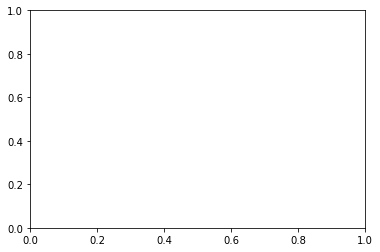

In [60]:
#print (kinases['Q9NYV4'].mechismo)
data = []
for acc in kinases:
    #print (kinases[acc].domains)
    for domainNum in kinases[acc].domains:
        #print (domainNum)
        data.append(len(kinases[acc].domains[domainNum]))

#print (data)
df = pd.DataFrame(data = data, columns=['Length'])
sns.histplot(data=df, x="Length")

print (kinases['Q92772'].dihedral)

In [70]:
for number, acc in enumerate(kinases):
    mutations = {}
    for dic, name in zip([kinases[acc].dihedral,
                          kinases[acc].sec,
                          kinases[acc].burr,
                          kinases[acc].access,
                          kinases[acc].iupred,
                          kinases[acc].mechismo,
                          kinases[acc].orthologs,
                          kinases[acc].exclParalogs,
                          kinases[acc].specParalogs,
                          kinases[acc].allHomologs,
                          kinases[acc].bpso,
                          kinases[acc].bpsh],
                        ['dihedral',
                         'access',
                         'burr',
                         'sec',
                         'iupred',
                         'mechismo',
                         'orthologs',
                         'exclParalogs',
                         'specParalogs',
                         'allHomologs',
                         'bpso',
                         'bpsh']):
        mutations[name] = {}
        for position in dic:
            if position not in mutations[name]:
                mutations[name][position] = {}
            mutations[name][position] = dic[position]
    l = '#Position\tMutation\tCategory\tScore\n'
    for name in mutations:
        for position in mutations[name]:
            for mutation in mutations[name][position]:
                l += str(position) + '\t' + mutation + '\t' + name + '\t' + str(mutations[name][position][mutation]) + '\n'
    #print (l)
    gzip.open('/net/home.isilon/ds-russell/kinaseResistance/KA/robScores/'+acc+'.tsv.gz', 'wt').write(l)
    print (number+1, 'of', len(kinases), 'done')
        

1 of 489 done
2 of 489 done
3 of 489 done
4 of 489 done
5 of 489 done
6 of 489 done
7 of 489 done
8 of 489 done
9 of 489 done
10 of 489 done
11 of 489 done
12 of 489 done
13 of 489 done
14 of 489 done
15 of 489 done
16 of 489 done
17 of 489 done
18 of 489 done
19 of 489 done
20 of 489 done
21 of 489 done
22 of 489 done
23 of 489 done
24 of 489 done
25 of 489 done
26 of 489 done
27 of 489 done
28 of 489 done
29 of 489 done
30 of 489 done
31 of 489 done
32 of 489 done
33 of 489 done
34 of 489 done
35 of 489 done
36 of 489 done
37 of 489 done
38 of 489 done
39 of 489 done
40 of 489 done
41 of 489 done
42 of 489 done
43 of 489 done
44 of 489 done
45 of 489 done
46 of 489 done
47 of 489 done
48 of 489 done
49 of 489 done
50 of 489 done
51 of 489 done
52 of 489 done
53 of 489 done
54 of 489 done
55 of 489 done
56 of 489 done
57 of 489 done
58 of 489 done
59 of 489 done
60 of 489 done
61 of 489 done
62 of 489 done
63 of 489 done
64 of 489 done
65 of 489 done
66 of 489 done
67 of 489 done
68 o

In [40]:
def fetchPkinase(acc, domainNum):
    '''
    A function to take acc and alignment cutoff values to return
    the HMM bitscores
    '''
    row = []
    for hmmPosition in range(1,265):
        if hmmPosition in kinases[acc].domains[domainNum]:
            SeqPosition = kinases[acc].domains[domainNum][hmmPosition]
            aa = kinases[acc].fasta[SeqPosition-1]
            value = float(hmmPkinase[hmmPosition][aa])
        else:
            value = 3

        row.append(value)
    #print (len(row))
    kinases[acc].hmm[domainNum] = row
    return row

def fetchStrucFeat(acc, domainNum):
    data = []
    df = pd.DataFrame()
    for dic, name in zip([kinases[acc].dihedral, kinases[acc].sec, kinases[acc].burr, kinases[acc].access, kinases[acc].iupred, kinases[acc].mechismo],
                        ['dihedral', 'access', 'burr', 'sec', 'iupred', 'mechismo']):
        row = []
        print (kinases[acc].dihedral)
        sys.exit()
        for hmmPosition in range(1,265):
            if hmmPosition in kinases[acc].domains[domainNum]:
                SeqPosition = kinases[acc].domains[domainNum][hmmPosition]
                residue = kinases[acc].fasta[SeqPosition-1]
                #print (SeqPosition)
                try:
                    value = dic[SeqPosition][residue]
                except:
                    print (acc, SeqPosition, len(dic), residue)
                    sys.exit()
            else:
                value = 3
            row.append(value)
        #f = pd.DataFrame(data, columns=AA)
        df[name] = row
    #print (df)
    
    return df

def fetchSeqFeat(acc, domainNum):
    data = []
    df = pd.DataFrame()
    for dic, name in zip([kinases[acc].orthologs, kinases[acc].exclParalogs, kinases[acc].specParalogs, kinases[acc].allHomologs, kinases[acc].bpso, kinases[acc].bpsh],
                        ['orthologs', 'exclParalogs', 'specParalogs', 'allHomologs', 'bpso', 'bpsh']):
        row = []
        for hmmPosition in range(1,265):
            if hmmPosition in kinases[acc].domains[domainNum]:
                SeqPosition = kinases[acc].domains[domainNum][hmmPosition]
                residue = kinases[acc].fasta[SeqPosition-1]
                #print (SeqPosition)
                try:
                    #print (dic[str(SeqPosition)])
                    for mutation in dic[str(SeqPosition)]:
                        if mutation[-1] == residue:
                            value = dic[str(SeqPosition)][mutation]
                            break
                except:
                    print (acc, SeqPosition, len(dic), residue)
                    sys.exit()
            else:
                value = 3
            row.append(value)
        #f = pd.DataFrame(data, columns=AA)
        df[name] = row
    #print (df)
    return df


def oneHotEncoding(acc, domainNum):
    '''
    A function to take acc and alignment cutoff values to return
    the feature matrix (one hot encoded)
    '''
    AA = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']
    #print (len(AA))
    data = []
    numZeros = 0
    for i in range(1,265):
        if i in kinases[acc].domains[domainNum]:
            position = kinases[acc].domains[domainNum][i]
            residue = kinases[acc].fasta[position-1]
        else:
            residue = '-'

        row = []
        for aa in AA:
            if residue == aa:
                row.append(1)
            else:
                row.append(0)
        data.append(row)
        '''
        if acc == 'Q96NX5' and i == 173:
            print (residue)
            print (row)
        '''
    data = np.array(data)
    kinases[acc].oneHotEncoding[domainNum] = data
    '''
    if data.shape == (264,len(AA)):
        #print (data.shape)
        trainData.append(data)
    '''
            
    #trainData = np.array(trainData)
    #print (np.stack(trainData, axis=0).shape)
    return (data, AA)

df = pd.DataFrame()
trainData = []
alignmentCutoff = 20
for acc in kinases:
    for domainNum in kinases[acc].domains:
        if len(kinases[acc].domains[domainNum]) >= alignmentCutoff:
            
            data, AA = oneHotEncoding(acc, domainNum)
            df = pd.DataFrame(data, columns=AA)
            df['HMM'] = fetchPkinase(acc, domainNum)
            df = pd.concat([df, fetchSeqFeat(acc, domainNum), fetchStrucFeat(acc, domainNum)], axis=1)
            #print (acc, kinases[acc].hmm)
            trainData.append(df.to_numpy())
        #break

print (df)
trainData = np.array(trainData)
'''
np.stack(trainData, axis=0)
print (trainData.shape)
np.save('trainData.npy', trainData)
numSamples, numRows, numCols = trainData.shape
'''

#for data in trainData:
#    print (data.shape)

{1: {'A': 0.86, 'C': 0.01, 'D': 0.29, 'E': 0.02, 'F': 0.84, 'G': 0.61, 'H': -1.21, 'I': -0.24, 'K': -0.06, 'L': -1.0, 'M': 0.0, 'N': -0.42, 'P': 0.4, 'Q': -0.92, 'R': 0.05, 'S': 0.53, 'T': 0.02, 'V': -0.59, 'W': 0.06, 'Y': -1.22}, 2: {'A': 0.15, 'C': -0.87, 'D': -0.52, 'E': 0.0, 'F': -0.43, 'G': -1.54, 'H': -0.85, 'I': -0.17, 'K': -0.21, 'L': 0.02, 'M': -0.08, 'N': -0.81, 'P': -1.0, 'Q': -0.09, 'R': -0.15, 'S': -0.73, 'T': -0.78, 'V': -0.41, 'W': -0.18, 'Y': -0.55}, 3: {'A': -0.22, 'C': -0.31, 'D': 0.22, 'E': -0.09, 'F': -0.27, 'G': -1.21, 'H': -0.07, 'I': -1.19, 'K': 0.0, 'L': -0.09, 'M': -0.1, 'N': 0.22, 'P': -0.64, 'Q': 0.03, 'R': -0.22, 'S': 0.03, 'T': -0.06, 'V': -1.27, 'W': 0.0, 'Y': -0.36}, 4: {'A': 1.73, 'C': 1.92, 'D': 2.31, 'E': 2.17, 'F': 1.55, 'G': 5.83, 'H': 3.54, 'I': 1.16, 'K': 2.22, 'L': 1.94, 'M': 0.9, 'N': 2.95, 'P': -1.96, 'Q': 2.04, 'R': 1.95, 'S': 2.23, 'T': 2.15, 'V': 1.16, 'W': -0.15, 'Y': 0.0}, 5: {'A': -0.46, 'C': 0.43, 'D': -0.75, 'E': 0.0, 'F': 0.96, 'G': -1.

SystemExit: 

/home/bq_gsingh/anaconda3/envs/kinaseR/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3405: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [136]:
trainData = np.load('trainData.npy')
print (trainData.shape)

(420, 264, 28)


In [132]:
## Create Sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Built encoder
latent_dim = 2

encoder_inputs = keras.Input(shape=(numRows, numCols, 1))
x = layers.Conv2D(20, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(50, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.BatchNormalization()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


## Built decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(66 * 7 * 50, activation="relu")(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Reshape((66, 7, 50))(x)
x = layers.Conv2DTranspose(50, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(20, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
#decoder_outputs = layers.Cropping2D(cropping=((0, 0), (0, 0)))(x)
#decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(decoder_outputs)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 264, 28, 1)] 0                                            
______________________________________________________________________________________

In [133]:
## Define VAE
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            '''
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            '''
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(
                        tf.subtract(data, reconstruction)
                    )
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

print (trainData.shape)
trainData = trainData.reshape(numSamples, numRows, numCols, 1)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(trainData, epochs=50, batch_size=10)

(420, 264, 28, 1)
Epoch 1/50
42/42 [==============================] - 20s 438ms/step - loss: 29110.5973 - reconstruction_loss: 23320.9590 - kl_loss: 727.0120
Epoch 2/50
42/42 [==============================] - 18s 440ms/step - loss: 16955.5536 - reconstruction_loss: 16577.1094 - kl_loss: 126.6032
Epoch 3/50
42/42 [==============================] - 19s 449ms/step - loss: 16245.0421 - reconstruction_loss: 16080.4580 - kl_loss: 64.8831
Epoch 4/50
42/42 [==============================] - 19s 458ms/step - loss: 16252.9916 - reconstruction_loss: 15932.6396 - kl_loss: 47.9422
Epoch 5/50
42/42 [==============================] - 19s 449ms/step - loss: 15910.1348 - reconstruction_loss: 15803.4463 - kl_loss: 37.4679
Epoch 6/50
42/42 [==============================] - 18s 440ms/step - loss: 15843.1061 - reconstruction_loss: 15606.2139 - kl_loss: 31.6131
Epoch 7/50
33/42 [======================>.......] - ETA: 4s - loss: 15115.2375 - reconstruction_loss: 15420.7344 - kl_loss: 28.5391

KeyboardInterrupt: 

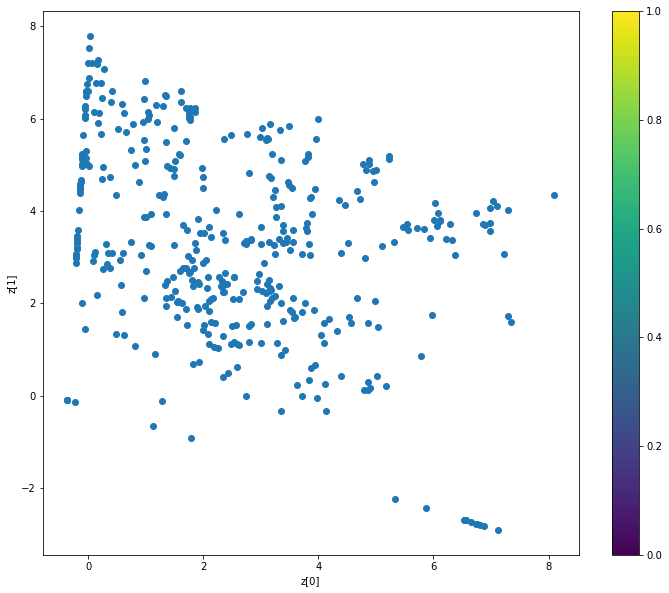

In [130]:
def plot_label_clusters(vae, data, labels=None):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


#(x_train, y_train), _ = keras.datasets.mnist.load_data()
#x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, trainData)
